<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/applied-computational-finance/blob/master/2021/1_notebooks/lesson_2_finite_difference_option_pricing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Finite Difference Methods for Derivatives Pricing

## Introduction ##

There are so many excellent resources (web tutorials, books, etc...) on finite difference method for the solution of differential equations in computational finance that writing yet another one
requires a different view on the topic. 

This notebook is not concerned with the traditional academic presentation of the topic, but is focused at teaching the practitioner how to obtain reliable computations involving finite difference methods. This focus is based on a set of learning outcomes:

1. understanding of the ideas behind finite difference methods,
2. understanding how to transform an algorithm to a computer code,
3. understanding how to test (verify) the code,
4. understanding potential artifacts in simulation results.

This notebook assumes some basic knowledge of differential equations and scientific Python programming,
as often met in an introductory numerical methods course. A significant portion of the text is consequently devoted
to programming details.


## Understanding Ideas behind Finite Difference Methods


In numerical analysis, [finite-difference methods (FDM)](https://en.wikipedia.org/wiki/Finite_difference_method) are discretizations used for solving *differential equations* by approximating them with difference equations in which finite differences approximate the derivatives. Finite difference methods for option pricing are numerical methods used in mathematical finance for the valuation of options. Finite difference methods were first applied to option pricing by Eduardo Schwartz in 1977.

In general, finite difference methods are used to price options by approximating the (continuous-time) differential equation that describes how an option price evolves over time by a set of (discrete-time) difference equations obtained by approximation of the partial derivative 

\begin{equation}
        \frac{\partial C}{\partial S} \Rightarrow \frac{\Delta C}{\Delta S}
\end{equation}

The discrete difference equations may then be solved iteratively to calculate a price for the option. The approach arises since the evolution of the option value can be modelled via a partial differential equation (PDE), as a function of (at least) time and price of underlying; see for example Black–Scholes PDE. Once in this form, a finite difference model can be derived, and the valuation obtained.

### A very simple example: the harmonic oscillator ###

Let's start from a very simple case, the harmonic oscillator. The problem is described by a simple **ODE (Ordinary Differential Equation)** of 2nd degree:

\begin{equation}
\frac{d^2u(t)}{dt^2} + \omega^2 \, u(t) = 0,\,
u(0)=I, \, u^\prime(0) =0, \, t \in (0,T]
\label{eqn:simple_harmonic_1}
\end{equation}

We know that the solution of this equation is a family of oscillatory functions like

$$
u(t) = I \,\cos{\omega t}
$$

but we want to discover this solution only using a numerical approach. The equation in of second degree so we need two initial condition, the first one could be the position of the oscillator at the beginning ($t=0$), the second usually describe a condition on the velocity. 


#### The Finite Difference Scheme

To formulate a finite difference method for the model problem we follow the following steps

**Step 1: Discretizing the domain**. The domain is discretized by introducing a uniformly partitioned time mesh. The points in the mesh are $t_n = n\Delta t,\> n = 0, 1, \dots ,N_t$, where $\Delta t = T/N_t$ is the constant length of
the time steps. We introduce a mesh function $u_n$ for $n = 0, 1, . . . ,N_t$, which approximates the exact solution at the mesh points. (Note that $n = 0$ is the known initial condition, so $u_n$ is identical to the mathematical
$u$ at this point.) The mesh function un will be computed from algebraic equations derived from the differential equation problem.

**Step 2: Fulfilling the equation at discrete time points**. The ODE (Ordinary Differential Equation) is
to be satisfied at each mesh point where the solution must be found:

\begin{equation}
u^{\prime\prime}(t_n) + \omega^2 u(t_n) = 0, \quad n = 1, . . . ,N_t
\end{equation}

**Step 3: Replacing derivatives by finite differences**. The derivative
$u^{\prime\prime}(t_n)$ is to be replaced by a finite difference approximation. A common
second-order accurate approximation to the second-order derivative is

\begin{equation}
f''(x) \sim \frac{f(x+h)-2f(x) + f(x-h)}{h^2} \Rightarrow 
u^{\prime\prime}(t_n) \sim 
\frac{u_{n+1} - 2u_n + u_{n-1}}{(\Delta t)^2}
\end{equation}

Inserting this yields

\begin{equation}
\frac{u_{n+1} - 2u_n + u_{n-1}}{\Delta t^2} = -\omega^2 u_n
\end{equation}

The **initial condition** for the velocity is simply $v=u^\prime=0$, we also need to replace the derivative in the initial condition by a
finite difference. Here we choose another centered difference approximation

\begin{equation}
f^\prime(x) \sim \frac{f(x+h)-f(x-h)}{2h} \Rightarrow
\frac{u[1]-u[-1]}{2\Delta t}=0
\end{equation}

**Step 4: Formulating a recursive algorithm**. To formulate the computational
algorithm, we assume that we have already computed $u_{n−1}$ and $u_n$, such that $u_{n+1}$ is the unknown value to be solved for. The ordinary differential equation $\eqref{eqn:simple_harmonic_1}$ becomes

$$
\frac{u[n+1] - 2 u[n] + u[n-1]}{\left( \Delta t \right)^2} = -\omega^2  \, u[n]  
$$
which finally give us 

$$
u[n+1] = 2\, u[n] - u[n-1] - \left(\Delta t \right)^2 \omega^2 \, u[n]
$$

$$
\text{
u[n+1] = 2 * u[n] - u[n-1] - dt**2 * w**2 * u[n]
}
$$

We observe that this equation cannot be used for $n=0$ since we have an undefined value of $u[-1]$ the condition on the velocity can help us because $v=0$ implies $u[1] = u[-1]$ so we have for $n = 0$

$$
u[1] = u[0] - 0.5*dt**2 * w**2 * u[0]
$$

**We have transformed our problem in an iterative equation (a *finite difference equation*) that starting from value at steps $n$ and $n-1$ gives us the value of our function to the next time step**. 

Now we are ready for coding. First of all let's import everything we need

In [4]:
%matplotlib inline
import math
import numpy             as np
import matplotlib.pyplot as plt

from math import pi

We have imported numpy and matplotlib under the names **np** and **plt**,
respectively, as this is very common in the Python scientific computing
community.

The algorithm from the previous section is readily translated to a complete
Python function for computing and returning $u_0, u_1, \dots , u_{N_t}$ and
$t_0, t_1, \dots , t_{N_t}$ , given the input $I$, $\omega$, $\Delta t$, and $T$:

In [5]:
def solver(I, w, dt, T):
    """
    Solve u'' + w**2*u = 0 for t in (0,T], u(0)=I and u'(0)=0,
    by a central finite difference method with time step dt.
    """
    dt   = float(dt)
    Nt   = int(round(T/dt))
    # initialize an array with Nt elements
    u    = np.zeros(Nt+1)
    # t is the temporal array, it is the independent variable in this problem
    t    = np.linspace(0, Nt*dt, Nt+1)
    #
    # initial conditions 
    #
    u[0] = I
    u[1] = u[0] - 0.5*dt**2*w**2*u[0]
    #
    # solution cycle
    #
    for n in range(1, Nt):
        u[n+1] = 2*u[n] - u[n-1] - dt**2*w**2*u[n]
    
    return u, t

Is also convenient to have a function for plotting the numerical and the exact solution 

In [6]:
def u_exact(t, I, w):
    return I*np.cos(w*t) 

In [7]:
def visualize(u, t, I, w):
    plt.plot(t, u, 'o', color='r')         # plot with circle red dots
    t_fine = np.linspace(0, t[-1], 1001)   # very fine mesh for u_e
    u_e = u_exact(t_fine, I, w)          
    plt.plot(t_fine, u_e,'b--', color='b')
    plt.xlabel('t')
    plt.ylabel('u')
    dt = t[1] - t[0]
    plt.title('dt=%g' % dt)
    umin = 1.2*u.min(); umax = -umin
    plt.axis([t[0], t[-1], umin, umax])

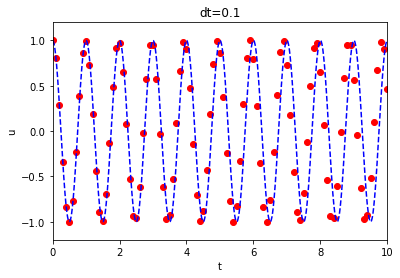

In [8]:
I           = 1
w           = 2*pi
dt          = 0.1
num_periods = 10
P           = 2*pi/w # one period
T           = P*num_periods

u, t = solver(I, w, dt, T)
visualize(u, t, I, w)



>**Exercise** 
>
>If you change the initial condition from 
>
>    u[1] = u[0] - 0.5*dt**2*w**2*u[0]
>
>to
>
>    u[1] = u[0] - 0.5*dt**2*w**2*u[0] + 1
>
>the form of the solution change and goes out of phase with respect to the theoretical solution. Why? Discuss the result.


#### Verification


>**Exercise** 
>
>The simplest type of verification, which is also
>instructive for understanding the algorithm, is to compute $u_1$, $u_2$, and
>$u_3$ with the aid of a spreadsheet and make a function for comparing these
>results with those from the solver function.


In [9]:
def test_three_steps():
    from math import pi
    I = 1; w = 2*pi; dt = 0.1; T = 1
    u_by_hand = np.array([1.000000000000000,0.802607911978213,
    0.288358920740053])
    u, t = solver(I, w, dt, T)
    diff = np.abs(u_by_hand - u[:3]).max()
    tol = 1E-14
    assert diff < tol

In [10]:
test_three_steps()

## Option Pricing

The discussion in this section focuses on the derivation of the fundamental partial differential equations for pricing European and American derivatives. One can reasonably ask under what conditions the price of a derivative is described by a partial differential equation. This is a complex issue that we do not elaborate to any significant extent. We'll just remember that the basic condition that allows us to obtain a partial differential equation for the option price is the **markovian nature** of the underlying process that determine the option price. Difficulties aries if the process is not markovian that is if the underlying process depends on the history of the Brownian motion that describes the process.

In the absence of jumps in the underlying process, there are fundamentally two different approaches for deriving the pricing equations for an European derivative. The first approach consists in constructing a hedging portfolio whose value tracks the value of the derivative as a function of time. The second approach is based on the [Faynmann-Kac Formula] (https://en.wikipedia.org/wiki/Feynman%E2%80%93Kac_formula), which states that the conditional expectation of a stochastic process obeys a partial differential equation. 

### Building a Uniform Grid

The stock-time (or S-t) plane is discretized into a grid of nodes. The examined time
points are $0,\Delta t, 2\Delta t, \dots, K\Delta t$, and the examined stock prices are 
$0,\Delta S, 2\Delta S,\dots, I\Delta S$.
The numerical solution of $f$ means to find the values for all $U_{i,k}$ , where $i$ and $k$ are the
indexes for the Stock price and the Time, respectively:

$$
    S = i \Delta S, \quad \quad t = T - k \Delta T
$$

**Figure 1.1**



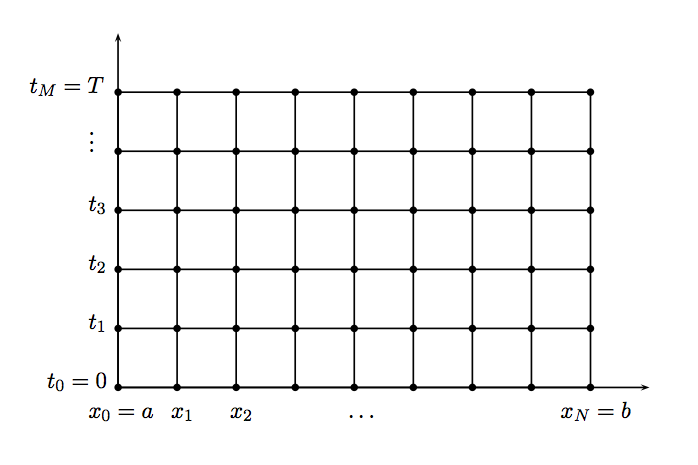

where $0 \le i \le I$ and $0 \le k \le K$. This means that we will be solving for the asset value going from zero up to the asset value $I\Delta S$. Remembering that the Black and Scholes equation is to be solved for $0 \le S \le \infty$, then $I \Delta S$ is our approximation to infinity. Please note that we are going backward in time starting from the expiration and going back to time 0. 

I will write the option value at each of these grid point as 

$$
U_{i,k} = U(i\Delta S, T - k \Delta t)
$$

### Discrete Approximation for Derivative

**Forward Approximation (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x+h)-f(x)}{h}+O(h)
\end{equation}

**Backward Approximation  (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x)-f(x-h)}{h}+O(h)
\end{equation}

**Central Approximation  (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x+h)-f(x-h)}{2h}+O(h^2)
\end{equation}


From Taylor's series we can obtain a valid approximation up to third order terms

\begin{align}
    &f(x+h) = f(x) + f^\prime(x) h + \frac{1}{2} f'' (x) h^2 + O(x^3) \notag\\
    &f(x-h) = f(x) - f^\prime(x) h + \frac{1}{2} f'' (x) h^2 + O(x^3) \notag\\
\end{align}

summing up we obtain

\begin{align}
    f''(x) =\frac{f(x+h)-2f(x) + f(x-h)}{h^2} + O(x^3)
\end{align}


### Final Conditions and Payoff ###

We know that at expiry the option value is just the payoff function. This means that we don't have to solve anything for time T. At expiry we have 

$$
U(S,t) = \text{Payoff}(S) \Rightarrow U_{i,0} = \text{Payoff}(i\Delta S)
$$

The right-hand side is a known function. For example, if we are pricing a call option we put

$$
U_{i,0} =  \max(i\Delta S - K, 0)
$$

This final condition will get our finite-difference scheme started. It will be just like working down the tree in the binomial model. 

### Boundary Condition ###

When we come to solving a PDE numerically we must specify the solution value at the extremes of the region. In our specific pricing problem this means that we have to prescribe the option value at $S=0$ and $S=I \Delta S$. What we specify will depend on the type of option we are solving. Let's see some examples.

**Call Option** - At $S=0$ we have always

\begin{equation}\label{eqn:boundary_condition_1}
U_{0,k}=0
\end{equation}

For large value of $S$ the call value approximate $S-Ke^{-r(T-t)}$ so we can set 

\begin{equation}\label{eqn:boundary_condition_2}
U_{I,k} = I \Delta S - Ke^{-rk \Delta t}
\end{equation}

**Put Option** - For a put option we have the condition at $S=0$ that $P=Ke^{-r(T-t)}$, this becomes   

\begin{equation}\label{eqn:boundary_condition_3}
U_{0,k} = Ke^{-rk \Delta t}
\end{equation}

The put option become worthless for large $S$ so

\begin{equation}\label{eqn:boundary_condition_4}
U_{I,k}=0
\end{equation}

When the option has a payoff that is most linear in the underlying for large value of $S$ then you can use the upper boundary condition

$$
\frac{\partial^2 U(S,t)}{\partial S^2} \rightarrow 0 \quad \text{as} \quad S \rightarrow \infty
$$

The finite-difference representation is

\begin{equation}\label{eqn:boundary_condition_5}
U_{I,k} - 2U_{I-1,k} + U_{I-2,k} = 0 \Rightarrow U_{I,k} = 2U_{I-1,k} - U_{I-2,k}
\end{equation}

## The Explicite Finite-Difference Method ##

Our goal is to solve the well known Black & Scholes PDE

\begin{equation}
\frac{\partial}{\partial t} U(S,t) +   \frac{1}{2}\sigma^2 S^2 \cdot \frac{\partial^2}{\partial S^2} U(S,t) + rS  \cdot  \frac{\partial}{\partial S} U(S,t)  -r  \cdot  U(S,t)   = 0   
\end{equation}

Let's rewrite the Black & Scholes PDE in a more general form to emphasize the wide applicability of the finite-difference method.

\begin{equation}\label{eqn:finite_difference_1}  
\frac{\partial}{\partial t} U(S,t) +   a(S) \cdot \frac{\partial^2}{\partial S^2} U(S,t) + b(S)  \cdot  \frac{\partial}{\partial S} U(S,t)  +  c(S)  \cdot  U(S,t)   = 0   
\end{equation}

Make the following substitutions and group the factors:

$$  \frac{\partial}{\partial t} U(S,t)   \longrightarrow   \frac{U_{i,k}-U_{i,k+1}}{\Delta t} $$
 
Note that for the time derivative we choose the **backward difference** at time $n$, while for the space derivative we choose the central difference:

\begin{align}
&\frac{\partial}{\partial S} U(S,t)    \longrightarrow   \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} \\
&\frac{\partial^2}{\partial S^2} U(S,t)   \longrightarrow   \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2}
\end{align}

whith these subsitutions we can write $\eqref{eqn:finite_difference_1}$ in the form

\begin{equation}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t} + a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k} = 0
\end{equation}

or

\begin{equation}
\frac{U_{i,k+1}-U_{i,k}}{\Delta t} = a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k}
\end{equation}

Now let's rewrite the finite difference equation putting the term at the time step $k+1$ on the
left side of the equal sign

\begin{align} 
U_{i,k+1} &= a \Delta t \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} +  b \Delta t  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} + \Delta t c U_{i,k} + U_{i,k} \notag\\
&= {a \Delta t \over \Delta S^2}U_{i+1,k} + {b \Delta t \over 2\Delta S}U_{i+1,k} -2 {a \Delta t \over \Delta S^2} U_{i,k} + \Delta t c U_{i,k} + U_{i,k} \notag\\
&+ {a \Delta t \over \Delta S^2}U_{i-1,k} - {b \Delta t \over 2\Delta S}U_{i-1,k} \notag\\
&= U_{i+1,k} \left[ {a\Delta t \over \Delta S^2} + {b\Delta t \over 2\Delta S} \right] \notag\\
&+ U_{i,k} \left[1 + \Delta tc  - 2 {a\Delta t \over \Delta S^2}   \right] \notag\\
&+ U_{i-1,k} \left[{a\Delta t \over \Delta S^2} - {b\Delta t \over 2\Delta S} \right]
\end{align}

to arrive to the following form
 
\begin{equation}\label{eqn:finite_difference_2}
U_{i,k+1} =   A  U_{i+1,k}    +  B  U_{i,k}   + C    U_{i-1,k} 
\end{equation}
 
with
 
\begin{align} 
& A = \frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b = \nu_1 a + \frac{1}{2}\nu_2 b \\
& B = 1 + \Delta t \> c - \frac{2\Delta t}{\Delta S^2} a = 1 -2 \nu_1 a + \Delta t \> c \\
& C = \frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b  = \nu_1 a - \frac{1}{2}\nu_2 b
\end{align}

where

$$ \nu_1 = \frac{\Delta t}{\Delta S^2}, \quad \quad \nu_2 = \frac{\Delta t}{\Delta S}$$

This is a finite difference equation where $U_{i,k+1}$'s can be calculated from $U_{i,k}$'s and so forth, at the boundary $U$ has to be fixed.

Equation $\eqref{eqn:finite_difference_2}$ is the core of the explicit finite difference method. It relates the derivative price at $t-\Delta t$ to three possible values of it at time $t$. So if, at time step $k$ we know $U_{i,k}$ for all $i$, we can explicitly calculate $U_{i,k+1}$. **This is why this method is called explicit and this is the reason why it can be easily generalized to handle the early exercise feature of american options**. This kind of generalization is not so easy for other computational methods for solving PDE.

The option value is know with certainty at expiration $T$. As we have already said, the price at time $t$ can be obtained by using $\eqref{eqn:finite_difference_2}$ recursively to work backward from time to time $t$. The explicit finite difference method has several features in common with a trinomial lattice.

### Python Implementation of Explicit Method ###

In [11]:
# local module
from gdl_finance.analytic import BlackScholes
from gdl_finance.trees    import *

In [12]:
S0    =  90.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.05  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

In [13]:
# Explicit Method

import math
import numpy as np
#
# Parameters to define the range in space and time
#
S_min = 0.0;
S_max = 200.0;
L     = S_max - S_min;

N     = 1000;               # Number of time steps
k     = float(T)/float(N);  # time step size
I     = 100;                # Number of space steps
h     = float(L)/float(I);  # space step size

sig   = sigma
sig2  = sig*sig

S     = np.zeros((I+1))
u     = np.zeros((I+1,N+1))

Here we choose the payout of this example. You can choose among 'call', 'put' 

In [14]:
payout = 'put'

Here we define payout and boundary condition for a call option. 
First of all we calculate the expiry value of a call option strategy expiring in a year. The payout is simply:

$$ f(S) = max(S(T)-K,0) $$
    
Remember that we used backward indexing of time , so maturity is $k = 0$ , the payout is the initial condition of the PDE $ U_{i,0}$. For large value of $S$ the call value approximate $S-Ke^{-r(T-t)}$ so we can set 

\begin{equation}
U_{I,k} = I \Delta S - Ke^{-rk \Delta t} \rightarrow u\left[I, n\right] = S\left[I\right] - K\,e^{r\cdot k\cdot n} 
\notag
\end{equation}

In [15]:
if payout == 'call':
    for i in range(0,I+1):
        S[i]   = i*h;
        u[i,0] = max(S[i]-K,0);
    #
    # We suppose that the range of S is sufficiently large, therefore impose the 
    # boundary conditions for all times:
    #
    # Value at the boundary 
    for n in range (0, N + 1):
        # If the underlying is zero even the option value is zero
        u[0,n] = 0.0;
        # for large values of the underlying value of the option tends asymptotically
        # to S - K * exp(-rt)
        u[I,n] = S[I] - K * math.exp(-r*k*n);

Here we define payout and boundary condition for a put option

In [16]:
if payout == 'put':
    for i in range(0,I+1):
        S[i] = i*h;
        u[i,0] = max(K - S[i],0);
    #
    # Value at the boundary 
    #
    for n in range (0, N + 1):
        u[0,n] = K * math.exp(-r*k*n);
        u[I,n] = 0.0;

Remember that

\begin{align} 
& A = \frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b  \notag\\
& B = 1 + \Delta t \> c - \frac{2\Delta t}{\Delta S^2} a  \notag\\
& C = \frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b \notag 
\end{align}

for the Black and Scholes equation we have

\begin{align} 
& a = \frac{1}{2} \sigma^2 S^2  \notag\\
& b = rS  \notag\\
& c = -r 
\end{align}

and due to the discretization process we have also $S = i \Delta S$ and $\Delta t = k$. Putting all this togheter we finally have

\begin{align}
&A_i = \frac{1}{2} \left( \sigma^2 i^2 + r i \right) \cdot k \notag\\
&B_i = 1 - \left( \sigma^2 i^2 +r \right) \cdot k \notag\\
&C_i = \frac{1}{2} \left( \sigma^2 i^2 - r i \right) \cdot k \notag
\end{align}

In [17]:
#
# Implementation of the explicit method
#
for n in range(0,N): # time loop
    for i in range (0,I): # space loop
        A = 0.5 * (sig2 * i * i + r * i ) * k
        B = 1.0 - (sig2 * i * i + r) * k 
        C = 0.5 * (sig2 * i * i - r * i) * k
        u[i,n+1] = A * u[i+1,n] + B * u[i,n] + C * u[i-1,n];
        #
        # early exercise condition
        #
        if payout == 'put':
            exercise = np.maximum(K-S[i],0)
        else:
            exercise = np.maximum(S[i]-K,0)
        if exercise > u[i, n+1]:
            u[i, n+1] = exercise                    

Graphical representation of the premium at different stock prices

Text(0.5, 1.0, 'Premium (green) - Payoff (red) for put')

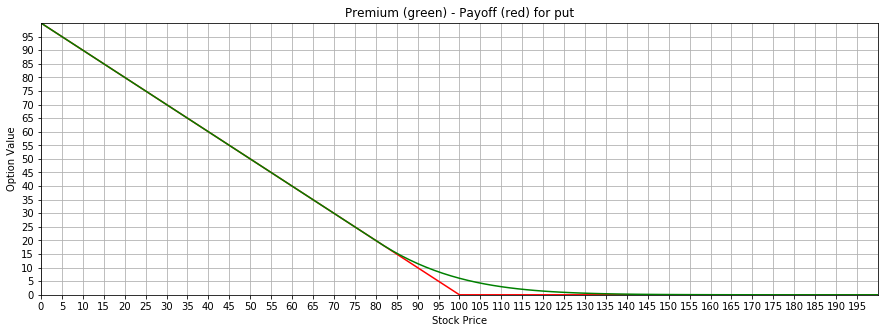

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

figure(figsize=(15,5))
grid()
plot(S,u[:,0],'r')
plot(S,u[:,N],'g')

xticks(arange(S_min,S_max,5))
yticks(arange(0,100,5))
ylim(0,100)
xlim(S_min, S_max)
xlabel('Stock Price')
ylabel('Option Value')
title('Premium (green) - Payoff (red) for ' + payout)

In [19]:
import scipy.interpolate

v = u[:,N]
f = scipy.interpolate.interp1d(S,v)

opt_european   = BlackScholes('P', S0, K, r, 0, sigma, T)
opt_binomial_e = binomial_model_european(N, S0, sigma, r, K, T)[1][0][0] 
opt_binomial_a = binomial_model_american(N, S0, sigma, r, K, T)[1][0][0]
opt_explicit   = f(S0).item(0)

print('Option price (analytic)               : ', round(opt_european,3))
print('Option price (binomial tree european) : ', round(opt_binomial_e,3))
print('Option price (binomial tree american) : ', round(opt_binomial_a,3))
print('Option price (explicit finite diff)   : ', round(opt_explicit,3))

Option price (analytic)               :  10.214
Option price (binomial tree european) :  10.215
Option price (binomial tree american) :  11.493
Option price (explicit finite diff)   :  11.483


### The log Black-Scholes Equation ###

Starting from the Black-Scholes PDE... 

\begin{equation}
\frac{\partial}{\partial t} U(S,t) +   \frac{1}{2}\sigma^2 S^2 \cdot \frac{\partial^2}{\partial S^2} U(S,t) + rS  \cdot  \frac{\partial}{\partial S} U(S,t)  -r  \cdot  U(S,t)   = 0   
\end{equation}

Let's say $Z = \ln S$, we have 

\begin{align}
&\frac{\partial U}{\partial S} = \frac{\partial U}{\partial Z}\frac{\partial Z}{\partial S} = \frac{1}{S} \frac{\partial U}{\partial Z} \notag\\
&\frac{\partial^2 U}{\partial S^2} = \frac{\partial}{\partial S} \left( \frac{1}{S} \frac{\partial U}{\partial Z} \right) = \frac{1}{S^2} \left( \frac{\partial^2 U}{\partial Z^2} - \frac{\partial U}{\partial Z} \right)
\end{align}

and we can write the $log$ BS PDE as

\begin{equation}
\frac{\partial}{\partial t} U(Z,t)  
+ \frac{1}{2}\sigma^2 \cdot \frac{\partial^2}{\partial Z^2} U(Z,t)
+ \left( r  - \frac{1}{2}\sigma^2 \right)\frac{\partial}{\partial Z} U(Z,t) 
-r  \cdot  U(Z,t)   = 0   
\end{equation}

a comparison with the general form give us:

\begin{align}
& a = \frac{1}{2} \sigma^2 \notag\\
& b = \left( r - \frac{1}{2} \sigma^2 \right) \notag\\
& c = -r \notag
\end{align}

The change of variable approach has the property that the various coefficient are now independent of $i$ and it can be shown that it is numerically most stable and efficient.



>**Exercise** 
>
>Implement the explicit method to solve the $log$ Black and Scholes equation.

### Connection with Tree ###

Now the discrete version with a small change in the last term (can you see it?) 

\begin{equation}
\frac{U_{i,k+1}-U_{i,k}}{\Delta t} = a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k+1}
\end{equation}

we can write

\begin{align} 
U_{i,k+1} \left( 1- c \Delta t\right)
&= U_{i+1,k} \left[ {a\Delta t \over \Delta S^2} + {b\Delta t \over 2\Delta S} \right] \notag\\
&+ U_{i,k} \left[1 - 2 {a\Delta t \over \Delta S^2}   \right] \notag\\
&+ U_{i-1,k} \left[{a\Delta t \over \Delta S^2} - {b\Delta t \over 2\Delta S} \right]
\end{align}

to arrive to the following form
 
\begin{equation}
U_{i,k+1} =   A  U_{i+1,k}    +  B  U_{i,k}   + C    U_{i-1,k} 
\end{equation}

with
 
\begin{align} 
& A = \frac{1}{1-c\Delta t}\left[\frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b \right] \notag\\
& B = \frac{1}{1-c\Delta t}\left[1 - \frac{2\Delta t}{\Delta S^2} a\right] \notag\\
& C = \frac{1}{1-c\Delta t}\left[\frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b\right]  \notag
\end{align}

substitution for $a, b, c$ values give us (remember that due to the discretization process we have also $S = i \Delta S$ and $\Delta t = k$)

\begin{align} 
& A = \frac{1}{1+r\Delta t}
\left[\frac{\Delta t}{2\Delta S^2} \sigma^2 S^2 + \frac{\Delta t}{2\Delta S} rS \right] =
\frac{1}{1+r\Delta t}
\left[\frac{1}{2} \sigma^2 i^2 \Delta t + \frac{1}{2} r i \Delta t \right] = 
\frac{1}{1+r\Delta t}
A^\star
\notag\\
& B = \frac{1}{1+r\Delta t}
\left[1 - \frac{\Delta t}{\Delta S^2} \sigma^2 S^2\right] =
\frac{1}{1+r\Delta t}
\left[1 -  \sigma^2 i^2 \Delta t\right] =
\frac{1}{1+r\Delta t}
B^\star
\notag\\
& C = \frac{1}{1+r\Delta t}
\left[\frac{\Delta t}{2\Delta S^2} \sigma^2 S^2 - \frac{\Delta t}{2\Delta S} rS\right]  =
\frac{1}{1+r\Delta t}
\left[\frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t \right] =
\frac{1}{1+r\Delta t}
C^\star
\notag
\end{align}

Now the relation with a trinomial tree is completely evident. Note that 

$$A^\star + B^\star + C^\star = 1$$


**Figure 1.2**

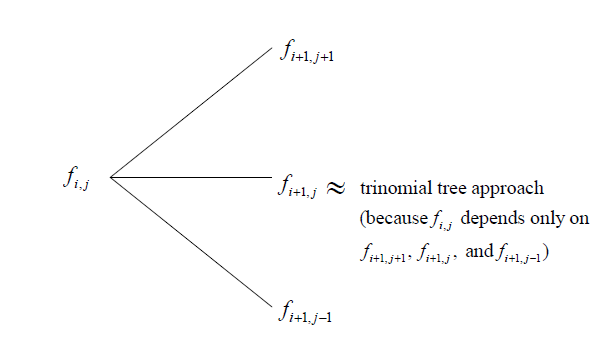

Infact we can interpret terms as follows

- $\frac{1}{2} \sigma^2 i^2 \Delta t + \frac{1}{2} r i \Delta t$ : probability of stock price increasing from $i\Delta S$ to $(i+1)\Delta S$ in time $\Delta t$;

- $1 -  \sigma^2 i^2 \Delta t$ : probability of stock price remaining unchanged at $i\Delta S$ in time $\Delta t$;  

- $\frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t$ : probability of stock price decreasing from $i\Delta S$ to $(i+1)\Delta S$ in time $\Delta t$;

and the value at time $k+1$ is simply the discounted value of the expectation a time $k$.

\begin{equation}
U_{i,k+1} =  \frac{1}{1+r\Delta t}
\left(
A^\star  U_{i+1,k}    +  B^\star  U_{i,k}   + C^\star    U_{i-1,k} 
\right)
\end{equation}

### Convergence of the Explicit Method ###

Although the explicit method is simple to implement it does not always converge. Convergence of the method depends on the size of the time step, the size of the asset step and the size of coefficients $a$, $b$ and $c$. Tipically there is a severe limitation on the size of the time step

$$
\Delta t \le \frac{\Delta S^2}{2a}
$$

if we want to improve accuracy by halving the asset step, for example, we must reduce the timestep by a factor of four. The computation time then goes up by a factor of eight. If the time step constraint is not satisfied, if it is too large, then the instability is obvious from the results. It is unlikely that you will get a false but believable result if you use the explicit method.

This can be understood very well by the analogy with the trinomial tree. Infact since all terms can be interpreted as probability, we must impose

$$ 1- \sigma^2 i^2 \Delta t \ge 0 \Rightarrow \sigma^2 i^2 \Delta t \le 1$$

from this taking into account that $S = i \Delta S$, 

$$ \Delta t \le \frac{1}{\sigma^2 S^2} \Delta S^2$$

And from the third probability 

$$ \frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t \ge 0 $$

we can easily find a constraint on the step size of $S$

$$ \Delta S \le \frac{\sigma^2 S}{r} $$

So, without any control we can have some "strange" results. Let's see what happens, we change the number of steps in time keeping constant the step in space (stock price). There are in generale regions in which the solution given by the explicit method is clearly unstable.

In [43]:
exact  = finite_difference_explicit('put', S0, K, sigma, T, True)
prices = []
nn     = range(1, 1000)
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    prices.append(finite_difference_explicit('put', S0, K, sigma, T, True, k, 50))

iter nr : 999

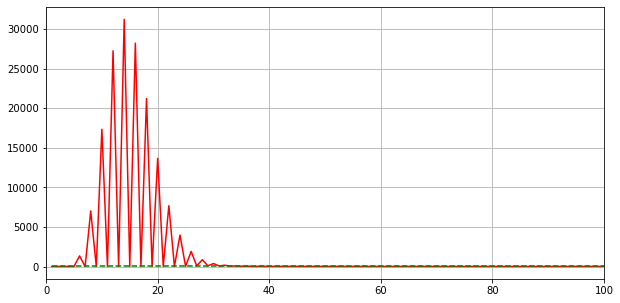

In [44]:
%matplotlib inline

ref = np.array([exact for n in nn])

fig = plt.figure(figsize=[10, 5])
plt.plot(nn, prices, color = 'r')
plt.plot(nn, ref,'b--',color = 'g')
#pl.ylim(0,10000)
plt.xlim(0,100)
plt.grid()
plt.show()


>**Exercise** 
>
>Implement the explicit method taking into considerations stability constraints.

### Conclusion ###

The advantages of the explicit method are the following:

- it is very easy to program and hard to make mistakes;
- when it does go unstable it is usually obviuos;
- it is easy to incorporate early exercise feature;

on the other hand there is a serious disadvantage due to the restrictions on the timestep so the method can be slower than other schemes. 


## Implicit Methods ##


### The Fully Implicit Method ###

The **fully implicit method** uses the points as shown in Figure (...) to calculate the option value. The scheme is superficially just like the explicit scheme but now the delta and gamma (first and second derivative with respect to $S$) are calculated at time step $k+1$ instead of $k$

\begin{equation}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t} + 
a_i \left( \frac{U_{i+1,k+1}- 2 U_{i,k+1}+U_{i-1,k+1}}{\Delta S^2} \right) + 
b_i \left( \frac{U_{i+1,k+1}-U_{i-1,k+1}}{2\Delta S} \right) +
c_i U_{i,k+1} = 0
\end{equation}

this can be written as 

\begin{equation}
U_{i,k} =   A_i  U_{i+1,k+1}    +  B_i  U_{i,k+1}   + C_i    U_{i-1,k+1} 
\end{equation}
 
with
 
\begin{align} 
& A_i = -\nu_1 a_i + \frac{1}{2}\nu_2 b_i \\
& B_i = 1 + 2 \nu_1 a_i - \Delta t \> c_i \\
& C_i = -\nu_1 a_i - \frac{1}{2}\nu_2 b_i
\end{align}

where as above

$$ \nu_1 = \frac{\Delta t}{\Delta S^2}, \quad \quad \nu_2 = \frac{\Delta t}{\Delta S}$$


**Figure 1.3**

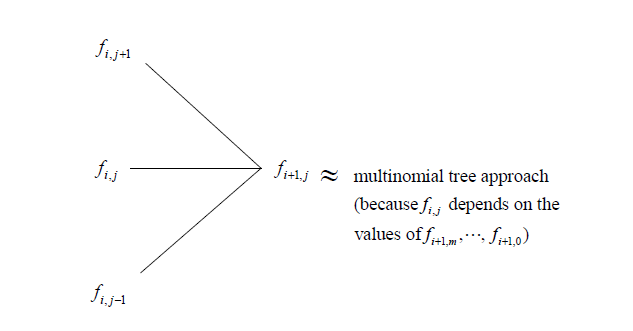

Also in this case this equation doesn't hold for $i=0$ or $i=I$ and the boundary conditions supply the two remaining equations. 

These scheme is very different from the explicit scheme, first of all it's possible to demonstrate that the method doesn't suffer anymore from the restriction on the time step. The asset step can be small and the time step large without the method running into stability problem. The second difference concern the solution procedure, infact the solution of the difference equation is no longer so straightforward. To get $U_{i,k+1}$ from $U_{i,k}$ we have to solve a set of linear equations, each $U_{i,k+1}$ is directly linked to its two neighbours and thus indirectly linked to every option value at the same time step.  

\begin{equation}
\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  
\end{array}  
\right]
=
\left[\begin{array}{c} U_{0,k} \\ U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}\\ U_{I,k}  \end{array} \right] 
\end{equation}

The matrix have $I-1$ rows and $I+1$ columns so this is a representation of $I-1$ equations in $I+1$ unknowns. The two equations that we are missing come from the boundary conditions. We can rewrite the previous equation taking explicitly into account the boundary conditions as:

\begin{equation}
\begin{bmatrix} 
   &  1+B_1 &  C_1    &  0      &  \cdots  
\\ &  A_2   &  1+B_2  &  C_2    &  \cdots  
\\ &  0     &  A_3    &  1+B_3  &  \cdots  
\\ & \ddots &  \ddots &  \ddots &  \vdots 
\\ & \cdots &  \cdots & A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c}  U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}   
\end{array}  
\right]
+
\left[
\begin{array}{c}  A_1U_{0,k+1} - U_{0,k} \\ 0  \\ \vdots \\ C_I U_{I,k+1} -U_{I,k}   
\end{array}  
\right]
=
\left[\begin{array}{c} U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}  \end{array} \right] 
\end{equation}

or

\begin{equation}
\begin{bmatrix} 
   &  1+B_1 &  C_1    &  0      &  \cdots  
\\ &  A_2   &  1+B_2  &  C_2    &  \cdots  
\\ &  0     &  A_3    &  1+B_3  &  \cdots  
\\ & \ddots &  \ddots &  \ddots &  \vdots 
\\ & \cdots &  \cdots & A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c}  U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}   
\end{array}  
\right]
=
\left[\begin{array}{c} U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}  \end{array} \right] 
-
\left[
\begin{array}{c}  A_1U_{0,k+1} - U_{0,k} \\ 0  \\ \vdots \\ C_I U_{I,k+1} -U_{I,k}   
\end{array}  
\right]
=
\left[
\begin{array}{c}  q_{1,k} \\ q_{2, k}  \\ \vdots \\ q_{I-1,k}   
\end{array}  
\right]
\end{equation}

$$
\mathbf{M_{imp}}\mathbf{U}=\mathbf{q}
$$

This matrix equation holds whichever of the boundary conditions we have. Solution methods are various but two of the most used are **LU Decomposition** and **Successive Over Relaxation**. The LU decomposition is an example of a 'direct method'. This means that it finds the exact solution of the equations in one go through matrix operations.  An alternative strategy is to employ an *iterative method*. Iterative methods differ from direct methods in that one starts with a guess for the solution and successively improves it until it converges near enough to the exact solution. In a direct method one obtains the solution without any interaction. An advantage of iterative methods over direct methods is that they generalise in straightforward ways to American option problems whereas direct methods do not. For this reason in the following we shall concentrate only on a particular kind of iterative method: the SOR (successive over-relaxation).

#### Successive Over-Relaxation Method (SOR) ####

This is an example of an 'indirect method', with this we solve the equations iteratively. We'll give a description of this method from a very generic point of view.

Suppose that the **square** matrix $\mathbf{M}$ in the matrix equation

$$
\mathbf{M}\mathbf{v}=\mathbf{q}
$$

has entries $M_{ij}$ then the system of equations can be written as

\begin{align}
&M_{11}v_1 + M_{12}v_2 + \dots + M_{1N}v_N = q_1 \notag\\
&M_{21}v_1 + M_{22}v_2 + \dots + M_{2N}v_N = q_2 \notag\\
&\dots \dots\notag\\
&M_{N1}v_1 + M_{N2}v_2 + \dots + M_{NN}v_N = q_N \\
\end{align}

$N$ is the number of equations. Rewrite this as

\begin{align}
&M_{11}v_1 = q_1 - (M_{12}v_2 + \dots + M_{1N}v_N )\notag\\
&M_{22}v_2 = q_2 - (M_{21}v_1 + \dots + M_{2N}v_N ) \notag\\
&\dots \dots\notag\\
&M_{NN}v_N = q_N - ( M_{N1}v_1 + \dots)\\
\end{align}

The system is easily *iteratively* using

\begin{align}
&v_1^{n+1} = \frac{1}{M_{11}} \left( q_1 - (M_{12}v_2^n + \dots + M_{1N}v_N^n )\right) \notag\\
&v_2^{n+1} = \frac{1}{M_{22}} \left( q_2 - (M_{21}v_1^n + \dots + M_{2N}v_N^n )\right) \notag\\
&\dots \dots\notag\\
&v_N^{n+1} = \frac{1}{M_{NN}} \left( q_N - ( M_{N1}v_1^n + \dots)\right)\\
\end{align}

where the superscript $n$ denotes the level of the iteration **and not the timestep**. This iteration is started from some initial guess $\mathbf{v}^0$. In our case it is usual to start with the value of the option at the previous timestep as the initial guess for the next timestep. This iterative method is called the **Jacobi Method**.

The matrix $\mathbf{M}$ can be written as the sum of a diagonal matrix $\mathbf{D}$, an upper triangular matrix $\mathbf{U}$ with zeros on the diagonal and a lower triangular matrix $\mathbf{L}$ also with zeros on the diagonal:

$$\mathbf{M} = \mathbf{D} + \mathbf{U} + \mathbf{L}$$

Using this representation we can write the Jacobi method in a different but elegant way

\begin{equation}
\mathbf{v}^{n+1} = \mathbf{D}^{-1} \left( \mathbf{q} - \mathbf{U}\cdot \mathbf{v}^n - \mathbf{L}\cdot \mathbf{v}^n \right)
\end{equation}

The idea of the *successive over-relaxation method* is to speed up convergence of the procedure using the right hand side of the previous equation as a correction factor of the value of $\mathbf{v}$ estimated at the previous step

\begin{equation}
\mathbf{v}^{n+1} = \mathbf{v}^{n+1} + \omega \mathbf{D}^{-1} \left( \mathbf{q} - \mathbf{U}\cdot \mathbf{v}^n - \mathbf{L}\cdot \mathbf{v}^n \right)
\end{equation}

$\omega$ is the so called *over-relaxation* parameter and its value must lie between 1 and 2. Usually this parameter is estimated by experiment making some test for the optimal value. 


### Python Implementation of Fully Implicit Method ###

In [20]:
payout = 'put'   # option type 

In [41]:
import sys
#
# Parameters to define the range in space and time
#
S_min  =   0.0;               # minimum value for stock price
S_max  = 150.0;               # maximum value for stock price
L      = S_max - S_min;

N      = 1002;                # Number of time steps
k      = float(T)/float(N);   # time step size
I      = 100;                 # Number of space steps
h      = float(L)/float(I);   # space step size

S      = np.zeros((I+1))      # stock price array   
A      = np.zeros((I+1))      #A, B and C are the constituents of matrix M
B      = np.zeros((I+1))
C      = np.zeros((I+1))
Payoff = np.zeros((I+1))      # option payoff
UOld   = np.zeros((I+1))      # value of option price at time t
UNew   = np.zeros((I+1))      # value of option price at time t+1
#
# Relaxation parameters
#
omega = 1.5
error = 1e6
#
# Precision parameters
#
EPS     = 0.00001
MAXITER = 100
#
# Initial Conditions. We Estimate the payoff and this is the value of the option
# at the starting time (remember that we compute time starting from option expiry!)
#
for i in range(0, I+1):
    S[i] = i * h
    if payout == 'call':
        UOld[i] = np.maximum(S[i] - K,0)
    else:
        UOld[i] = np.maximum(K - S[i],0)    
Payoff = UOld


The implicit method matrix coefficients are

\begin{align} 
& A_i = -\nu_1 a_i + \frac{1}{2}\nu_2 b_i \notag\\
& B_i = 1 + 2 \nu_1 a_i - \Delta t \> c_i \notag\\
& C_ = -\nu_1 a_i - \frac{1}{2}\nu_2 b_i  \notag
\end{align}

so due to discretization process they transform into

\begin{align}
&A_i = -\frac{1}{2} i \> k \left( \sigma^2 i - r \right) \notag\\
&B_i = 1 + k \left( \sigma^2 i^2 +r \right) \notag\\
&C_i = - \frac{1}{2} k \> i \left( \sigma^2 i + r \right) \cdot k \notag
\end{align}

In [22]:
#
# Matrix elements
#
for i in range(1,I):
    A[i] = -k * 0.5 * i * (sigma * sigma * i - r)
    B[i] =  1 + 1.0 * k * (sigma * sigma * i * i + r)
    C[i] = -k * 0.5 * i * (sigma * sigma * i + r)

Note that in our parametrization, $A$ is the subdiagonal matrix, $C$ is the superdiagonal matrix and $B$ is the diagonal one.

In [27]:
#
# Cycle on time
#
for n in range(1, N-1):
    sys.stdout.write("\r" + "Now running time step nr: " + str(n) + "/" + str(N-2))
    sys.stdout.flush()
    t = n * k
    #
    # initially UNew is set equal to UOld
    #
    UNew[1:I-1] = UOld[1:I-1]
    m = 0
    #
    # Boundary Conditions
    #
    if payout == 'call':
        UNew[0] = 0
        UNew[I] = h * I * math.exp(-delta * t) - K * math.exp(-r * t)
    else:
        UNew[0] = K * math.exp(-r * t)
        UNew[I] = 0

    while (error > EPS) and (m < MAXITER): 
        error = 0
        for i in range(1,I):
            y       = (UOld[i] - A[i] * UNew[i - 1] - C[i] * UNew[i + 1] ) / B[i]
            diff    = y - UNew[i]
            error   = error + diff * diff
            UNew[i] = UNew[i] + omega * diff
            #
            # this is were we introduce the early exercise 
            #
            UNew[i] = max(UNew[i], Payoff[i])
        m = m + 1
    #
    UOld[1:I-1] = UNew[1:I-1]

f = scipy.interpolate.interp1d(S,UNew)
opt_implicit = f(S0).item(0)

print('\r')
print('Option price (implicit finite diff)   : ', round(opt_implicit,3))

Now running time step nr: 1000/1000
Option price (implicit finite diff)   :  13.696


### The Crank-Nicolson Method ###

The Fully Implicit Method can be significantly improved with a relatively limited computational effort.

This method can be thought of as an average of the explicit method and the fully implicit method. It uses the six points shown in Figure (...).

The Crank-Nicolson scheme is 

\begin{align}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t}  
&+ \frac{a_i}{2}\left( \frac{U_{i+1,k+1}- 2 U_{i,k+1}+U_{i-1,k+1}}{\Delta S^2} \right)
 + \frac{a_i}{2}\left(\frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2}\right)\notag\\
&+ \frac{b_i}{2}\left( \frac{U_{i+1,k+1}-U_{i-1,k+1}}{2\Delta S} \right)
 + \frac{b_i}{2}\left( \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S}  \right)\notag\\
&+ \frac{1}{2}c_i U_{i,k}
 + \frac{1}{2}c_i U_{i,k+1}
= 0
\end{align}

This can be written as

\begin{equation}
-A_i  U_{i-1,k+1} + (1 - B_i) U_{i,k+1} - C_i U_{i+1,k+1} =
 A_i  U_{i-1,k} + (1 + B_i) U_{i,k} + C_i U_{i+1,k}
\end{equation}

where

\begin{align} 
& A = \frac{1}{2}\nu_1 a_i + \frac{1}{4}\nu_2 b_i \\
& B = - \nu_1 a_i + \frac{1}{2} \Delta t \> c_i \\
& C = \frac{1}{2}\nu_1 a_i - \frac{1}{4}\nu_2 b_i
\end{align}

These equations only hold for $1 \le i \le I-1$. The boundary contitions again supply the two missing equations but in this case they are harder to deal with than in the explicit methods. We shall return on this subject in a while.

\begin{align}
&\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  \end{array} \right] 
= \\
&\begin{bmatrix} 
-A_1 &  1-B_1 &  -C_1 &  0 &  \cdots &  0 
\\ 0 &  -A_2 &  1-B_2  &  -C_2 &  \cdots &  0 
\\ 0 &  0 &  -A_3 &  1-B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   -A_{I-1} &  1-B_{I-1} & - C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k} \\ U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}\\ U_{I,k}  \end{array} \right] 
\end{align}

The two matrices have $I-1$ rows and $I+1$ columns so this is a representation of $I-1$ equations in $I+1$ unknowns. The two equations that we are missing come from the boundary conditions.



#### Boundary Conditions ####

**$U_{0,k+1}$ and/or $U_{I,k+1}$ given**

We can write

\begin{equation}
\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  \end{array} \right] 
\end{equation}

as 

\begin{equation}
\begin{bmatrix} 
1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{1,k+1} \\ U_{2,k+1} \\ U_{3,k+1}  \\ \vdots \\ U_{I-1,k+1}  \end{array} \right] 
+
\left[\begin{array}{c} A_1U_{0,k+1} \\ 0 \\ 0  \\ \vdots \\ C_{I-1}U_{I,k+1}  \end{array} \right] 
= \mathbf{M}_L^{k+1} \mathbf{U}_{k+1} + \mathbf{r}_k
\end{equation}

We can do the same for the right hand side of the equation, so we finally get

\begin{equation}
\mathbf{M}_L^{k+1} \mathbf{U}_{k+1} + \mathbf{r}_k = \mathbf{M}_R^{k} \mathbf{U}_{k}
\end{equation}

The solution of this matrix equation can be implemented using the SOR method we discussed previously.





>**Exercise**
>
>Try to code the Crank-Nicolson Method with Python. Apply to the solution of the Black and Scholes equation.


# References #

*John C. Hull*, **Option, Futures and Other Derivatives**, 6th Edition, Prentice Hall

*Domingo Tavella and Cut Randall*, **Pricing Financial Instrument: The Finite Difference Approach**, Wiley

*Paul Wilmott*, **Derivatives, The Theory and Practice of Financial Engineering**, University Edition

*Paul Wilmott, Sam Howison and Jeff Dewinne*, **The Mathematics of Financial Derivatives, A Student Introduction**, Cambridge University Press

# Appendix - Function Code #

In [28]:
def finite_difference_explicit(payout, S0, K, sigma, T, american = True, N = 1000, I = 100):
    #
    # N is the Number of time steps
    # I is the Number of space steps 
    #
    #
    # Parameters to define the range in space and time
    #
    S_min = 0.0;
    S_max = 200.0;
    L     = S_max - S_min;

    k     = float(T)/float(N);  # time step size
    h     = float(L)/float(I);  # space step size

    sig   = sigma
    sig2  = sig*sig

    S     = np.zeros((I+1))
    u     = np.zeros((I+1,N+1))

    if payout == 'call':
        for i in range(0,I+1):
            S[i]   = i*h;
            u[i,0] = max(S[i]-K,0);
        #
        # We suppose that the range of S is sufficiently large, therefore impose the 
        # boundary conditions for all times:
        #
        # Value at the boundary 
        for n in range (0, N + 1):
            # If the underlying is zero even the option value is zero
            u[0,n] = 0.0;
            # for large values of the underlying value of the option tends asymptotically
            # to S - K * exp(-rt)
            u[I,n] = S[I] - K * math.exp(-r*k*n);

    if payout == 'put':
        for i in range(0,I+1):
            S[i] = S_min + i*h;
            u[i,0] = max(K - S[i],0);
        #
        # Value at the boundary 
        #
        for n in range (0, N + 1):
            u[0,n] = K * math.exp(-r*k*n);
            u[I,n] = 0.0;
    #
    # Implementation of the explicit method
    #
    for n in range(0,N): # time loop
        for i in range (0,I): # space loop
            A = 0.5 * (sig2 * i * i + r * i ) * k
            B = 1.0 - (sig2 * i * i + r) * k 
            C = 0.5 * (sig2 * i * i - r * i) * k
            u[i,n+1] = A * u[i+1,n] + B * u[i,n] + C * u[i-1,n];
            #
            # early exercise condition
            #
            if payout == 'put':
                exercise = np.maximum(K-S[i],0)
            else:
                exercise = np.maximum(S[i]-K,0)
            if american:    
                u[i, n+1] = np.maximum(exercise, u[i, n+1]) 
    
    f = scipy.interpolate.interp1d(S,u[:,N])
    return f(S0).item(0)               

In [39]:
def finite_difference_implicit(payout, S0, K, sigma, T, american = True, N = 1000, I = 250):
    import sys
    #
    # Parameters to define the range in space and time
    #
    S_min  =   0.0;
    S_max  = 150.0;
    L      = S_max - S_min;

    k      = float(T)/float(N);   # time step size
    h      = float(L)/float(I);   # space step size

    S      = np.zeros((I+1))
    A      = np.zeros((I+1))
    B      = np.zeros((I+1))
    C      = np.zeros((I+1))
    Payoff = np.zeros((I+1))
    UOld   = np.zeros((I+1))
    UNew   = np.zeros((I+1))
    #
    # Relaxation parameters
    #
    omega = 1.5
    error = 1e6
    #
    # Precision parameters
    #
    EPS     = 0.00001
    MAXITER = 100
    #
    # Initial Conditions
    #
    for i in range(0, I+1):
        S[i] = i * h
        if payout == 'call':
            UOld[i] = np.maximum(S[i] - K,0)
        else:
            UOld[i] = np.maximum(K - S[i],0)    
    Payoff = UOld
    #
    # Matrix elements
    #
    for i in range(1,I):
        A[i] = -k * 0.5 * i * (sigma * sigma * i - r)
        B[i] = 1 + 1.0 * k * (sigma * sigma * i * i + r)
        C[i] = -k * 0.5 * i * (sigma * sigma * i + r)
    #
    # Cycle on time
    #
    for n in range(1, N-1):
        #sys.stdout.write("\r" + "Now running time step nr: " + str(n) + "/" + str(N-2))
        #sys.stdout.flush()
        t = n * k
        #
        # initially UNew is set equal to UOld
        #
        UNew[1:I-1] = UOld[1:I-1]
        m = 0
        #
        # Boundary Conditions
        #
        if payout == 'call':
            UNew[0] = 0
            UNew[I] = h * I * math.exp(-delta * t) - K * math.exp(-r * t)
        else:
            UNew[0] = K * math.exp(-r * t)
            UNew[I] = 0

        while (error > EPS) and (m < MAXITER): 
            error = 0
            for i in range(1,I):
                y       = (UOld[i] - A[i] * UNew[i - 1] - C[i] * UNew[i + 1] ) / B[i]
                diff    = y - UNew[i]
                error   = error + diff * diff
                UNew[i] = UNew[i] + omega * diff
                #
                # this is were we introduce the early exercise opportunity
                #
                if american:
                    UNew[i] = max(UNew[i], Payoff[i])
            m = m + 1
        #
        UOld[1:I-1] = UNew[1:I-1]

    print('\r')
    f = scipy.interpolate.interp1d(S,UNew)
    return f(S0).item(0)

In [35]:
S0    =  80.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.01  # short rate
sigma =   0.25  # volatility
delta =   0.0   # dividend yield

In [36]:
payout = -1
N      = 250

opt_european   = BlackScholes(payout, S0, K, r, 0, sigma, T)
opt_binomial_e = binomial_model_european(N, S0, sigma, r, K, T, 'put')[1][0][0] 
opt_binomial_a = binomial_model_american(N, S0, sigma, r, K, T, 'put')[1][0][0]
opt_explicit   = finite_difference_explicit('put', S0, K, sigma, T, True)
opt_implicit   = finite_difference_implicit('put', S0, K, sigma, T, True)

print('Option price (analytic)               : ', round(opt_european,3))
print('Option price (binomial tree european) : ', round(opt_binomial_e,3))
print('Option price (binomial tree american) : ', round(opt_binomial_a,3))
print('Option price (explicit finite diff)   : ', round(opt_explicit,3))
print('Option price (implicit finite diff)   : ', round(opt_implicit,3))        

Now running time step nr: 998/998
Option price (analytic)               :  21.429
Option price (binomial tree european) :  21.424
Option price (binomial tree american) :  21.689
Option price (explicit finite diff)   :  21.687
Option price (implicit finite diff)   :  21.687


In [48]:
import sys

exact  = finite_difference_implicit('put', S0, K, sigma, T, True, 1000)
prices = []
nn     = range(1, 1000)
for k in nn:
    sys.stdout.write('\r' + 'iter nr : ' + str(k))
    sys.stdout.flush()
    prices.append(finite_difference_implicit('put', S0, K, sigma, T, True, k, 50))

KeyboardInterrupt: 

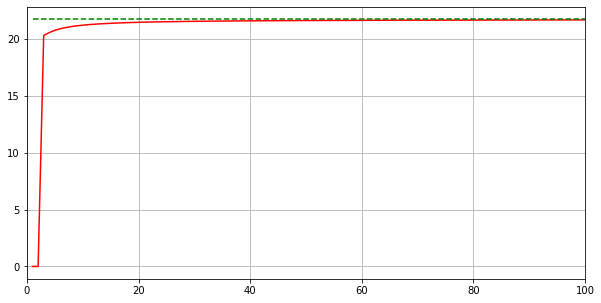

In [46]:
%matplotlib inline

ref = np.array([exact for n in nn])

fig = plt.figure(figsize=[10, 5])
plt.plot(nn, prices, color = 'r')
plt.plot(nn, ref,'b--',color = 'g')
#pl.ylim(0,10000)
plt.xlim(0,100)
plt.grid()
plt.show()